# Wrangle Act
### By Julio Uribe

The purpose of this project is to expand on wrangling abilities. In this file we will gather data about "weRateDogs" twitter posts from a couple of different sources: using the udacity provided twitter enhanced file for tweet id's, directly pulling from Twitter API, and pulling from udacity's server to look at neural net results in a tsv file. Next we'll assess the data and see how to best structure and combine the data. After that we'll clean as many quality and structural issues we can so that our data will be ready for analysis.

### Setup: Import  Modules

In [95]:
import tweepy
from tweepy import OAuthHandler
import json
import numpy as np
from timeit import default_timer as timer
import pandas as pd
import requests

# 1) Gather Data

### a) First Source File: Twitter Enhanced file and set up API keys

In [96]:
#load file info into dataframe for tweet id's to use later
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
#load tweet ids for api extraction
tweet_ids = twitter_archive.tweet_id.values

#Set up API credentials from file outside directory
creds = []
with open('/Users/Jules/Desktop/DAND/twitter_credentials.txt', 'r') as f:
    creds = f.read().split("'")
consumer_key = creds[1]
consumer_secret = creds[3]
access_token = creds[5]
access_secret = creds[7]
#create auth object with keys
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
#create tweepy api object for requests
api = tweepy.API(auth, wait_on_rate_limit = True)

print (len(tweet_ids))

2356


### b) Second Source File: Query Twitter's API for JSON data

In [ ]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # Loop pauses/resumes at about 900 tweets due to api's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

### c) Load JSON data we got from Twitter API into a cleaner dataframe

In [97]:
#load twitter json file into a pandas dataframe
tweets_json_full = pd.read_json("tweet_json.txt", lines=True)
#tweets_json_full.info()

#create a smaller version of tweets_json_full with only the columns we're interested in
tweets_json = pd.DataFrame(tweets_json_full[['id', 'created_at', 'favorite_count', 'retweet_count', 'full_text', 'extended_entities']])
#tweets_json.head()

### d) Third Source file: Use Requests Module to Load Neural Net Results

In [100]:
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open("image_predictions.tsv", 'wb') as file:
    for chunk in r.iter_content(chunk_size=128):
        file.write(chunk)
#read file back in and create a df for image predictions data     
image_predictions = pd.read_csv("image_predictions.tsv", sep='\t')

# 2) Assessing Data

For this project, we have three dataframes we're currently working with: 
* twitter_archive - imported tweet info from twitter_archive_enhanced.txt provided by udacity. Has tweet IDs, tweet text, ratings, and other information.
* tweets_json - data from twitter API containing retweets, favorited count, tweet text, and more.
* image_predictions - results from neural net. Contains three predictions, image url, number of images, etc.

The three dataframes provide info about the tweets posted from the WeRateDogs twitter profile. We'll do some assessing of the data before we merge these dataframes together. Then we'll clean the data to get the most complete data set we can.

### Tidiness Issues
* twitter_archive has 2356 entries, tweets_json has 2340 entries, and image_predictions has 2075 entries. They all serve the same purpose of giving us more info about individual tweets. Should merge all three
* In 'twitter_archive', the last four columns (doggo, floofer, pupper, puppo) are not always observed and best serve as a category. We should combine these 4 columns into one

### Quality Issues
##### *twitter_archive*
* Doggo, pupper, floofer, puppo cols will become redundant once we add new 'stage' column
* 'None' values are strings but should be NaN values. True for all three tables
* Incorrect and missing names under 'name' column: 'None', 'a', 'the', 'an', etc.
* Rating numerators are under 10 but according to the twitter profile, all ratings should be above 10 and less than 20
* Rating numerators should be float to be more inclusive and account for future ratings
* Ther are rows where the 'rating_denominator' is lower or higher than 10. We need to standardize all rows to be out of 10.
* Timestamp column is in string format instead of datetime.

##### *tweets_json*
* 'Id' column should be renamed to 'tweet_id' to be consistent with other two dataframes
* duplicate 'created_at' column that is equivalent to twitter_archive 'timestamp' column. We'll keep one
* we'll have duplicate 'full_text' columns as well after merging

##### *image_predictions*
* Dog breed predictions from the neural net in p1 give us results in inconsistent lower/upper case usage
* We get results from our neural net in p1 that don't include dogs such as 'desktop_computer', 'electric_fan', 'wild_boar'.
* Some prediction of dog breeds aren't actual dog breeds

### Assessing Code

In [ ]:
#twitter_archive
# twitter_archive has 2356 entries, tweets_json has 2340 entries, and image_predictions has 2075 entries. We'll merge later
# on tweet IDs.
#twitter_archive.describe()
#tweets_json.info()
#twitter_archive.isnull().sum()
#type(twitter_archive.timestamp[0])
#twitter_archive.source.value_counts()
#twitter_archive.name.value_counts()
#twitter_archive.rating_denominator.value_counts()
#twitter_archive.rating_numerator.value_counts()
#tweets_json
# tweets_json.isnull().sum()
# tweets_json.info()
# image_predictions.isnull().sum()
# image_predictions
# image_predictions.describe()
#image_predictions.p1.value_counts()
# image_predictions.p1.value_counts()
#image_predictions.p3.value_counts()
# if it hits false multiple times, toss out row
#image_predictions[image_predictions.p3 == 'space_shuttle']
#image_predictions[image_predictions.p1 == 'coffee_mug'].jpg_url
# there's a good chance that a large part of our data set doesn't actually contain dogs in the image, throwing off ratings
#image_predictions['p1_dog'].mean(), image_predictions['p2_dog'].mean(), image_predictions['p3_dog'].mean()
# explore prediction results for tweets with more than one image. How does the neural net handle multiple images?
# multi_pic = image_predictions[image_predictions["img_num"] > 1]
# multi_pic
# lets compare the average p1_dog, p2_dog, p3_dog rates from multiple images to the whole dataframe
# multi_pic['p1_dog'].mean(), multi_pic['p2_dog'].mean(), multi_pic['p3_dog'].mean()
# Multiple images is more likely to have a dog in it than the general dog prediciton rate from entire dataframe
#checking for duplicated values
# twitter_archive[twitter_archive.tweet_id.duplicated()]
# tweets_json[tweets_json.id.duplicated()]
# image_predictions[image_predictions.tweet_id.duplicated()]

# 3) Cleaning Data

### a) Create copies for data

In [117]:
# Create copies of all three dataframes
twitter_archive_clean = twitter_archive.copy()
tweets_json_clean = tweets_json.copy()
image_predictions_clean = image_predictions.copy()

### b) First Merge and Cleaning

In [118]:
# Define: Rename 'id', 'created_at', and 'text' in the dataframes for consistency
# Clean
tweets_json_clean.rename(columns={'id':'tweet_id', 'created_at': 'timestamp'}, inplace=True)
twitter_archive_clean.rename(columns={'text':'full_text', 'created_at': 'timestamp'}, inplace=True)
# Test: Make sure column names are consistent when shared/overlapping
#twitter_archive_clean.columns, tweets_json_clean.columns

In [119]:
# Define: Drop extra columns that are less interesting and only keep data that is mostly complete and easy to interpret
#Clean
twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], axis=1, inplace=True)
tweets_json_clean.drop(['extended_entities'], axis=1, inplace=True)
# Test: Make sure all the appropriate columns have been deleted
#twitter_archive_clean.columns, tweets_json_clean.columns

In [120]:
# Define: Merge the twitter_enhanced_clean and tweets_json_clean together using 'tweet_id'
tweets_super_clean = tweets_json_clean.merge(twitter_archive_clean, how='inner', on='tweet_id')
# Test: let's see what columns we have now and if the merge is doing what we want it to do
#tweets_super_clean.head()
#tweets_super_clean.info()

In [121]:
# Define: before we move onto our second merge, we need to remove duplicate columns
# timestamp_x and timestamp_y show the same data. Timestamp_x is in the datetime format we want so we'll keep that one
# two columns for full text as well. We'll keep the first one
# Drop the columns
tweets_super_clean.drop(['timestamp_y', 'full_text_y'], axis=1, inplace=True)
# Rename the columns
tweets_super_clean.rename(columns={'timestamp_x':'timestamp', 'full_text_x': 'full_text'}, inplace=True)
# Test: verify our column remmoval was clean and successful
tweets_super_clean.columns

Index(['tweet_id', 'timestamp', 'favorite_count', 'retweet_count', 'full_text',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

### c) Second Merge

In [122]:
# Define
# We'll now merge tweets_super_clean with image_predictions_clean using tweet_ids
tweets_super_clean = tweets_super_clean.merge(image_predictions_clean, on='tweet_id', how='inner')
# Test: Confirm column names
tweets_super_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 23 columns):
tweet_id              2066 non-null int64
timestamp             2066 non-null datetime64[ns]
favorite_count        2066 non-null int64
retweet_count         2066 non-null int64
full_text             2066 non-null object
rating_numerator      2066 non-null int64
rating_denominator    2066 non-null int64
name                  2066 non-null object
doggo                 2066 non-null object
floofer               2066 non-null object
pupper                2066 non-null object
puppo                 2066 non-null object
jpg_url               2066 non-null object
img_num               2066 non-null int64
p1                    2066 non-null object
p1_conf               2066 non-null float64
p1_dog                2066 non-null bool
p2                    2066 non-null object
p2_conf               2066 non-null float64
p2_dog                2066 non-null bool
p3                    2066 non-nu

### d) Create new category column 'stage' to replace 4 columns: doggo, pupper, floofer, puppo

In [123]:
# Define
# Create new stage column combining the 4 other dog stage columns and use 'mixed' when more than one stage is available
# combine all 4 columns
tweets_super_clean['stage'] = tweets_super_clean['doggo']+tweets_super_clean['floofer']+ \
                    tweets_super_clean['pupper']+tweets_super_clean['puppo']
# remove the None characters from all the strings
tweets_super_clean['stage'] = tweets_super_clean['stage'].str.replace('None', '')
# replace empty strings with NaN values
tweets_super_clean['stage'] = tweets_super_clean['stage'].replace('', np.nan)
# Fix values that include multiple stages and replace with 'mixed'
stages = {'doggopupper': 'mixed',
                'doggopuppo': 'mixed',
                'doggofloofer': 'mixed'}
def find_mixed(tweets_super_clean):
    if tweets_super_clean['stage'] in stages.keys():
        new_stage = stages[tweets_super_clean['stage']]
        return new_stage
    else:
        return tweets_super_clean['stage']    
tweets_super_clean['stage'] = tweets_super_clean.apply(find_mixed, axis=1)
# Test: confirm that all stage values are either: pupper, doggo, puppo, floofer, or mixed
tweets_super_clean['stage'].value_counts()

pupper     211
doggo       67
puppo       23
mixed       13
floofer      7
Name: stage, dtype: int64

### Drop old dog stage columns

In [124]:
# Define
# Drop 4 columns that we don't need anymore since all the information is in the 'stage' column
tweets_super_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)
# rearrange the new stage column before the image prediction columns
tweets_super_clean = tweets_super_clean[['tweet_id', 'timestamp', 'favorite_count', 'retweet_count', 'full_text',
       'rating_numerator', 'rating_denominator', 'name', 'stage', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog']]
# Test
tweets_super_clean.head()

,tweet_id,timestamp,favorite_count,retweet_count,full_text,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,37806,8244,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,32488,6091,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,24452,4029,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,41150,8389,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,39341,9094,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


### e) Replace 'None' string values with proper NaN values for missing data

In [125]:
# Define
# Replace 'None' values with proper NaN values for missing data
tweets_super_clean.replace('None', np.nan, inplace=True)
# Test: Confirm changes are reflected in our dataframe
tweets_super_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 20 columns):
tweet_id              2066 non-null int64
timestamp             2066 non-null datetime64[ns]
favorite_count        2066 non-null int64
retweet_count         2066 non-null int64
full_text             2066 non-null object
rating_numerator      2066 non-null int64
rating_denominator    2066 non-null int64
name                  1491 non-null object
stage                 321 non-null object
jpg_url               2066 non-null object
img_num               2066 non-null int64
p1                    2066 non-null object
p1_conf               2066 non-null float64
p1_dog                2066 non-null bool
p2                    2066 non-null object
p2_conf               2066 non-null float64
p2_dog                2066 non-null bool
p3                    2066 non-null object
p3_conf               2066 non-null float64
p3_dog                2066 non-null bool
dtypes: bool(3), datetime64[ns](1),

### f) Standardize denominator ratings to be out of 10

In [127]:
# Define
# Standardize all the denominators value to be at 10 for proper consistent rating scale
# Clean
tweets_super_clean.rating_denominator = 10
# Test
tweets_super_clean.rating_denominator.value_counts()

10    2066
Name: rating_denominator, dtype: int64

### g) Find incorrect names and replace with NaN values

In [128]:
# Define
# Correct all 'a', 'the', 'an', etc. dog names by replacing them with NaN values
# Bad names tend to start with lowercase so we'll put all the lower case names into a list of bad_names
bad_names = ['None']
# put all the names into a series
names_left = tweets_super_clean.name.value_counts()
for i in names_left.index:
    if i.islower():
        bad_names.append(i)
# iterate through our df and replace bad names with NaN values
for bad_name in bad_names:
    tweets_super_clean.name.replace(bad_name, np.nan, inplace=True)
tweets_super_clean.name.value_counts()

Penny      10
Oliver     10
Lucy       10
Tucker     10
Cooper     10
Charlie    10
Lola        8
Winston     8
Sadie       8
Bo          8
Toby        7
Daisy       7
Dave        6
Scout       6
Koda        6
Bella       6
Stanley     6
Milo        6
Rusty       6
Jax         6
Bailey      6
Louis       5
Buddy       5
Alfie       5
Larry       5
Oscar       5
Chester     5
Leo         5
Loki        4
Clark       4
           ..
Pluto       1
Filup       1
Aiden       1
Colin       1
Theo        1
Chase       1
Jay         1
Rumpole     1
Harnold     1
Beebop      1
Lizzie      1
Brandi      1
Sage        1
Dallas      1
Bloop       1
Odin        1
Barney      1
Cheryl      1
Rooney      1
Sailor      1
Wishes      1
Strider     1
Dwight      1
Pilot       1
Jo          1
Tino        1
Bloo        1
Furzey      1
Monster     1
Eugene      1
Name: name, Length: 912, dtype: int64

### h) Extract new numerator ratings to account for edge cases.

In [195]:
# Define: Values less than 10 and significantly over 10-19 range should not be valid. I will reassign the numerator using
# a regex that limits the range its looking for to only contain values from 10-19 and are tied to a '/10'
# We will replace the old numerator with this new rating of type float
# Clean
# tweets_super_clean['new_rating'] = tweets_super_clean.full_text.str.extract('(1[0-9]?[.]?[0-9]+?/10)', expand=True)
tweets_super_clean['new_rating'] = tweets_super_clean.full_text.str.extract('(1[0-9][.]?[0-9]*?/10)', expand=True)
tweets_super_clean['new_rating'] = tweets_super_clean['new_rating'].str[:-3]
tweets_super_clean['new_rating'] = tweets_super_clean['new_rating'].astype(float)
tweets_super_clean.new_rating.value_counts()
# find the row with the 1776 value
tweets_super_clean[tweets_super_clean['new_rating'] == 1776.0]
# reassign that value with nan since its not in our range
tweets_super_clean.at[796, 'new_rating'] = np.nan
# assess all ratings are within intended range
tweets_super_clean.new_rating.value_counts()
tweets_super_clean.head()

,tweet_id,timestamp,favorite_count,retweet_count,full_text,rating_numerator,rating_denominator,name,stage,jpg_url,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,new_rating
0,892420643555336193,2017-08-01 16:23:56,37806,8244,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,13.0
1,892177421306343426,2017-08-01 00:17:27,32488,6091,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,13.0
2,891815181378084864,2017-07-31 00:18:03,24452,4029,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,12.0
3,891689557279858688,2017-07-30 15:58:51,41150,8389,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,13.0
4,891327558926688256,2017-07-29 16:00:24,39341,9094,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,12.0


In [196]:
# reassign numerator_rating to new_rating and delete new_rating column
tweets_super_clean['rating_numerator'] = tweets_super_clean['new_rating']
tweets_super_clean.drop(['new_rating'], axis=1, inplace=True)

# Assess
tweets_super_clean.rating_numerator.value_counts()
tweets_super_clean.query("rating_numerator == 11.26").full_text.values
tweets_super_clean.query("rating_numerator == 13.50").full_text.values

array(['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948'],
      dtype=object)

### i) Clean up case usage on nueral net predictions. Uppercase first letter of each word

In [199]:
# Define: Use consistent case for all p1, p2, p3 breed predictions
# Code
tweets_super_clean.p1 = tweets_super_clean.p1.str.title()
tweets_super_clean.p2 = tweets_super_clean.p2.str.title()
tweets_super_clean.p3 = tweets_super_clean.p3.str.title()
# Assess
tweets_super_clean.p1
tweets_super_clean.p2
tweets_super_clean.p3
tweets_super_clean.head()

,tweet_id,timestamp,favorite_count,retweet_count,full_text,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,37806,8244,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,32488,6091,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,24452,4029,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,41150,8389,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper_Towel,0.170278,False,Labrador_Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,39341,9094,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English_Springer,0.225770,True,German_Short-Haired_Pointer,0.175219,True


### j) Save clean dataframe to CSV file

In [202]:
# save clean df as twitter_archive_master.csv
tweets_super_clean.to_csv('twitter_archive_master.csv', index=False)

# 4) Analyze and Visualize Clean Dataframe

In [203]:
tweets_master = pd.read_csv('twitter_archive_master.csv')
tweets_master.head()

,tweet_id,timestamp,favorite_count,retweet_count,full_text,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,37806,8244,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,32488,6091,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,24452,4029,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,41150,8389,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper_Towel,0.170278,False,Labrador_Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,39341,9094,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English_Springer,0.225770,True,German_Short-Haired_Pointer,0.175219,True


### Insights and Visualization

In [210]:
# How many tweets have valid ratings
1 - (tweets_master.rating_numerator.isnull().sum()/(len(tweets_master.rating_numerator)))

0.7947725072604066

In [213]:
# Average number of retweets
tweets_master.retweet_count.mean()

2778.9501452081317

In [214]:
# tweet average dog rating
tweets_master.rating_numerator.mean()

11.44398903775883

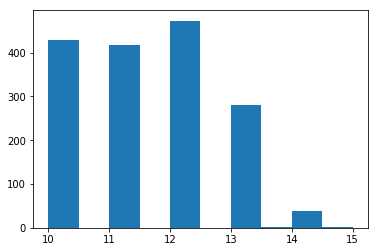

In [221]:
# import visualization modules
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(tweets_master.rating_numerator);